In [1]:
import copy
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss, MASE, mase_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# 1. Load data

In [3]:
X_train_full = pd.read_csv('data/X_train_full.csv', parse_dates=['delivery_start_utc']).set_index('delivery_start_utc')
y_train_full = pd.read_csv('data/y_train_full.csv', parse_dates=['delivery_start_utc']).set_index('delivery_start_utc')
y_pred_external_full = pd.read_csv('data/y_pred_external.csv', parse_dates=['delivery_start_utc']).set_index('delivery_start_utc')

In [5]:
X_train_full.merge(y_train_full, how='left', right_index=True, left_index=True).merge(y_pred_external_full, how='left', right_index=True, left_index=True)

,weekday,month,price_lag_24,co2_price_pln_actual_lag_24,co2_price_eur_actual_lag_24,load_forecast_lag_24,capacity_jwcd_forecast_lag_24,capacity_njwcd_forecast_lag_24,generation_jwcd_forecast_lag_24,generation_njwcd_forecast_lag_24,...,Hard coal 1000 available_lag_168,Hard coal 200 available_lag_168,Hard coal 500 available_lag_168,Lignite 200 available_lag_168,Lignite 300 available_lag_168,Hard coal 300 available_lag_168,Lignite 500 available_lag_168,Lignite 1000 available_lag_168,price,forecast_PLN
delivery_start_utc,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,1,1,119.00,32.28,7.77,16125.0,20575.0,6648.0,10485.0,5640.0,...,2720.0,11469.0,572.0,2127.0,4244.0,1532.0,954.0,858.0,118.90,NaN
2018-01-08 01:00:00,1,1,118.90,32.28,7.77,15450.0,20575.0,6686.0,9772.0,5678.0,...,2720.0,11469.0,572.0,2127.0,4244.0,1532.0,954.0,858.0,118.90,NaN
2018-01-08 02:00:00,1,1,117.98,32.28,7.77,15100.0,20575.0,6763.0,9345.0,5755.0,...,2720.0,11329.0,572.0,2127.0,4244.0,1532.0,954.0,858.0,118.90,NaN
2018-01-08 03:00:00,1,1,117.98,32.28,7.77,14925.0,20575.0,6861.0,9072.0,5853.0,...,2720.0,11329.0,572.0,2127.0,4244.0,1532.0,954.0,858.0,118.90,NaN
2018-01-08 04:00:00,1,1,117.98,32.28,7.77,14925.0,20575.0,6922.0,9014.0,5911.0,...,2720.0,11329.0,572.0,2127.0,4244.0,1532.0,954.0,858.0,135.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,4,1,244.58,145.47,32.13,22050.0,24333.0,7711.0,15114.0,6936.0,...,2885.0,11263.5,1532.0,2562.0,4614.0,1149.0,474.0,858.0,239.50,225.613956
2020-12-31 20:00:00,4,1,216.48,145.47,32.13,21450.0,24333.0,7682.0,14534.0,6916.0,...,2885.0,11239.0,1532.0,2562.0,4614.0,1149.0,474.0,858.0,227.00,220.507092
2020-12-31 21:00:00,4,1,215.00,145.47,32.13,20225.0,24333.0,7648.0,13343.0,6882.0,...,2885.0,11219.0,1532.0,2562.0,4614.0,1149.0,474.0,858.0,229.75,207.238365


In [6]:
VALIDATION_SIZE = 30*24 #30 days * 24 hours (december 2020 for validation)

X_train, X_valid = X_train_full.iloc[:(-VALIDATION_SIZE), :], X_train_full.iloc[(-VALIDATION_SIZE):, :]
y_train, y_valid = y_train_full.iloc[:(-VALIDATION_SIZE)].loc[:,'price'], y_train_full.iloc[(-VALIDATION_SIZE):].loc[:,'price']

y_pred_external = y_pred_external_full.iloc[y_pred_external_full.index==y_valid.index,:].loc[:,'forecast_PLN']
benchmark_valid_error = np.sqrt(mean_squared_error(y_pred=y_pred_external, y_true=y_valid))

data_batches = [
    X_train, 
    X_valid,
    y_train,
    y_valid,
    y_pred_external,
]
for data_batch in data_batches:
    data_batch.index.freq = '1H'

# 2. Naive forecasters

In [7]:
def fit_forecaster(forecaster, y_train, y_valid, forecaster_name=None, plot=True):
    forecaster.fit(y_train)
    fh_index = y_valid.index
    fh = ForecastingHorizon(fh_index, is_relative=False)
    y_pred = forecaster.predict(fh)
    if plot:
        plot_series(y_valid, y_pred, y_pred_external, labels=['y_true', 'y_pred', 'y_pred_external'])
        plt.grid()
        if forecaster_name:
            plt.title(f'Forecaster: {forecaster_name}', fontsize=20)
    
    rmse_valid = np.sqrt(mean_squared_error(y_true=y_valid, y_pred=y_pred))
    rmse_ext = np.sqrt(mean_squared_error(y_true=y_valid, y_pred=y_pred_external))
    if forecaster_name:
            print(f'Forecaster {forecaster_name} results:')
    print(f'Naive forecaster RMSE: {rmse_valid}. External predictions RMSE: {rmse_ext}')
    return rmse_valid

Naive forecaster RMSE: 77.822836434394. External predictions RMSE: 34.117237015574034


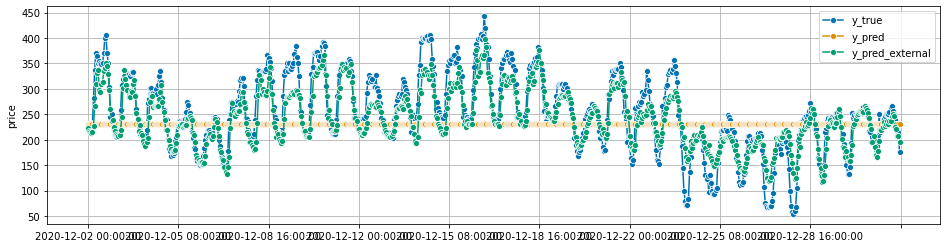

In [8]:
naive_forecaster = NaiveForecaster(strategy='last')
rmse_valid = rmse = fit_forecaster(naive_forecaster, y_train, y_valid)

Naive forecaster RMSE: 68.65545525079887. External predictions RMSE: 34.117237015574034


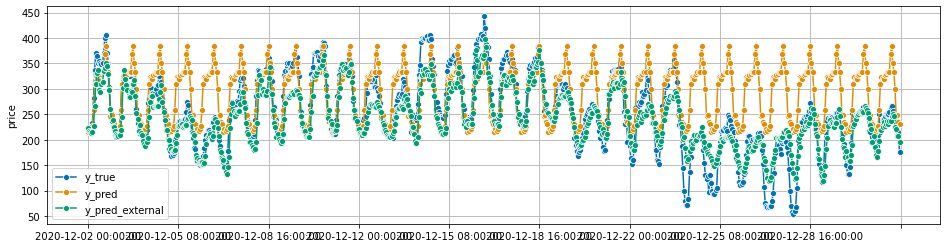

In [9]:
naive_forecaster = NaiveForecaster(strategy='last', sp=24)
rmse_valid = fit_forecaster(naive_forecaster, y_train, y_valid)

In [10]:
naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
}

Forecaster sp1_last results:
Naive forecaster RMSE: 77.822836434394. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_1 results:
Naive forecaster RMSE: 82.35112357899084. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_2 results:
Naive forecaster RMSE: 82.98247392872543. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_3 results:
Naive forecaster RMSE: 75.52582938835815. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_4 results:
Naive forecaster RMSE: 74.96368342093002. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_5 results:
Naive forecaster RMSE: 75.6772701653578. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_6 results:
Naive forecaster RMSE: 75.78480609570967. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_7 results:
Naive forecaster RMSE: 75.91814981032917. External predictions RMSE: 34.117237015574034
Forecaster sp1_mean_all results:
Naive forecaster RMS

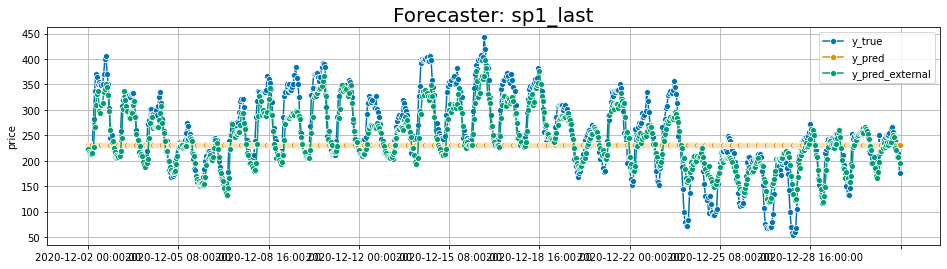

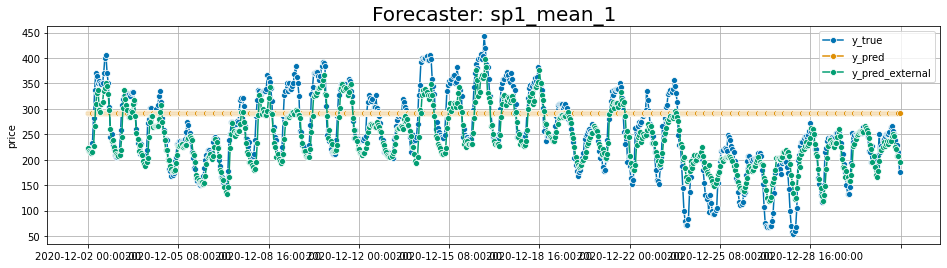

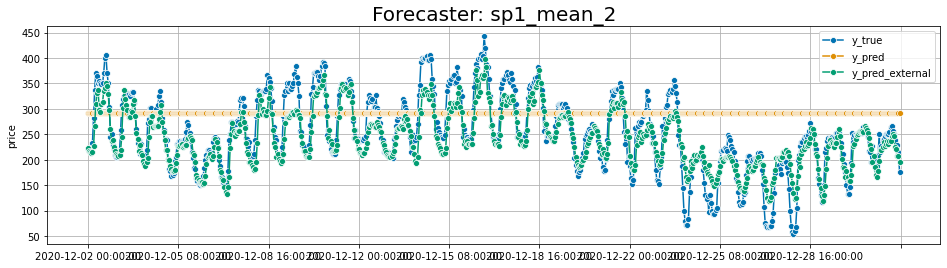

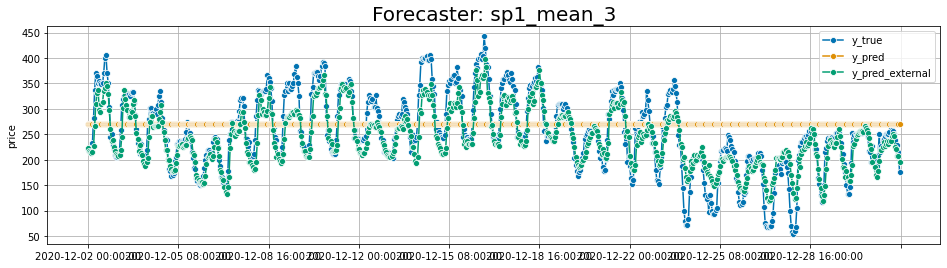

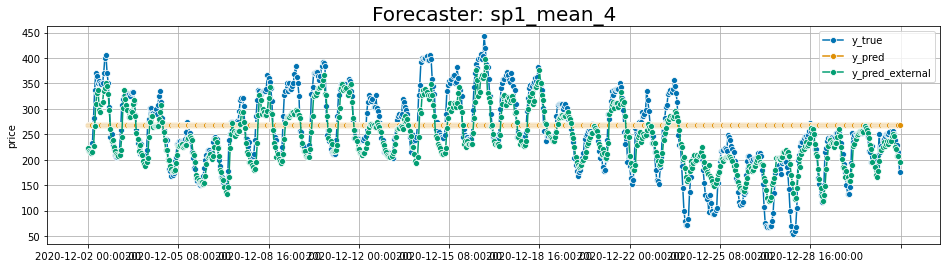

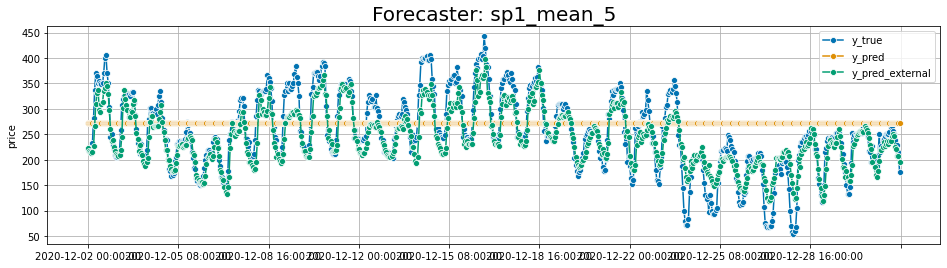

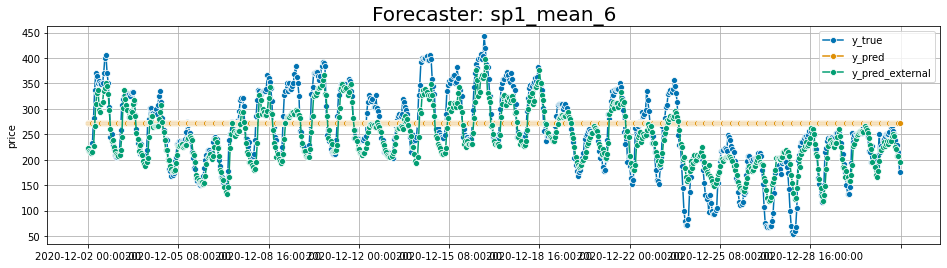

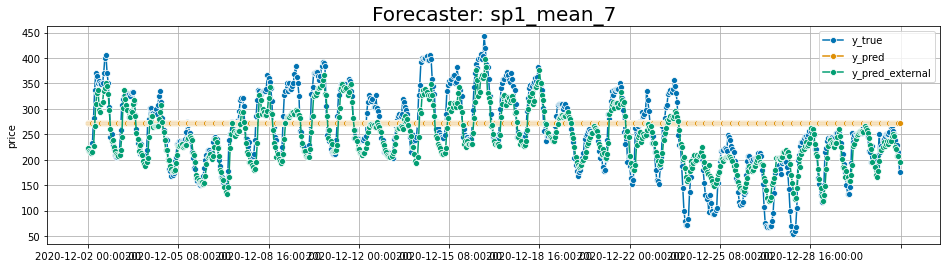

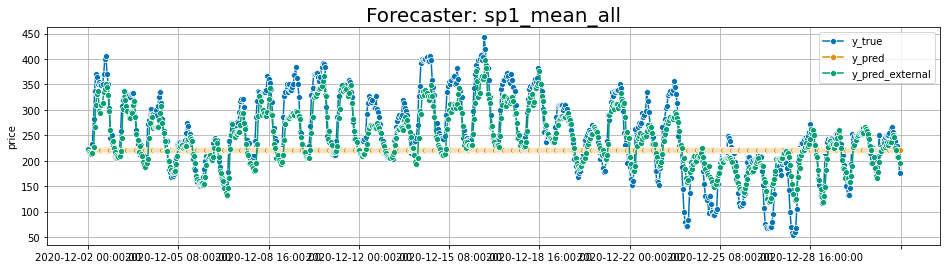

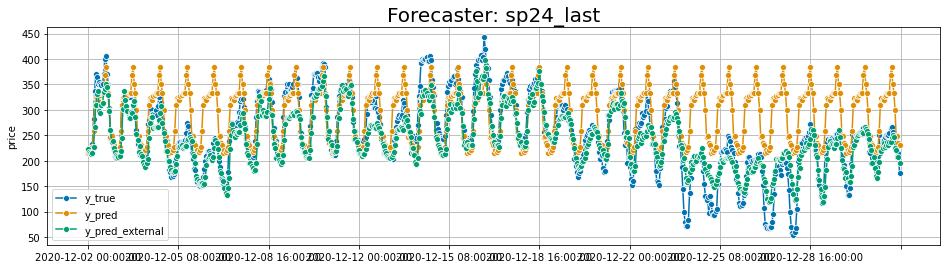

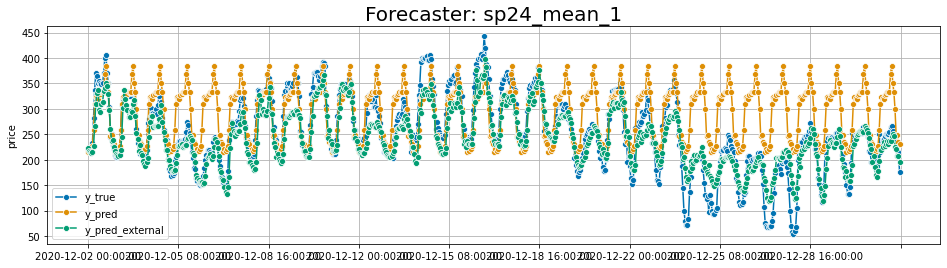

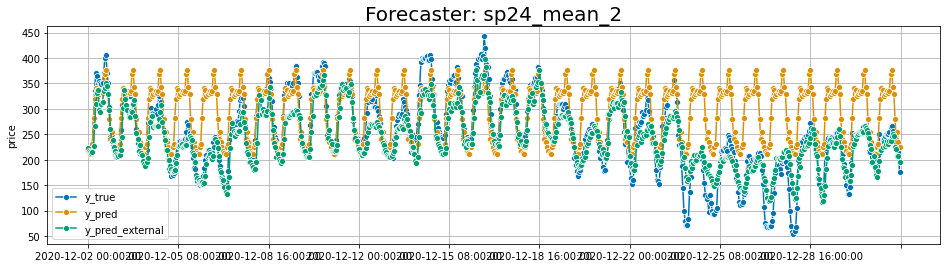

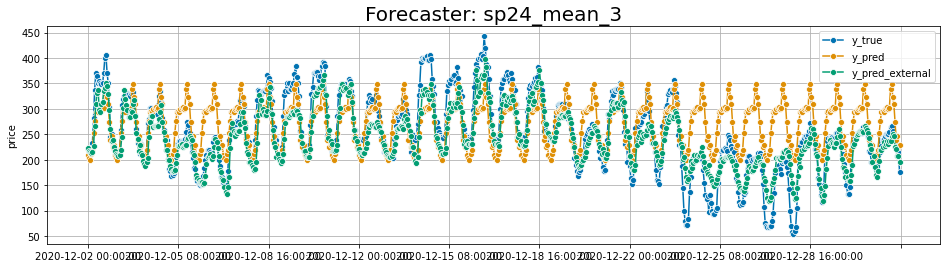

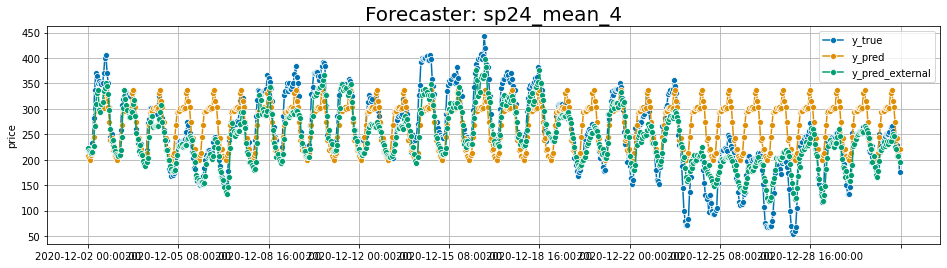

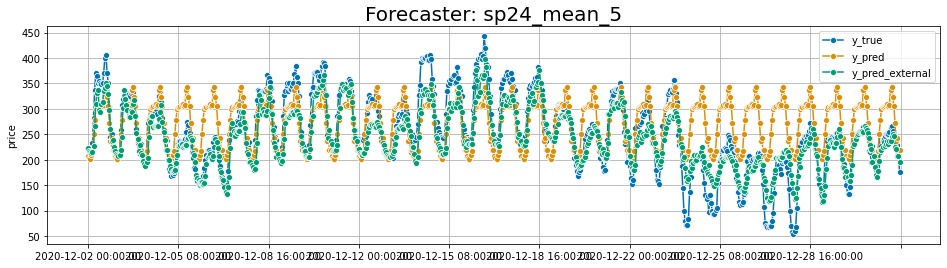

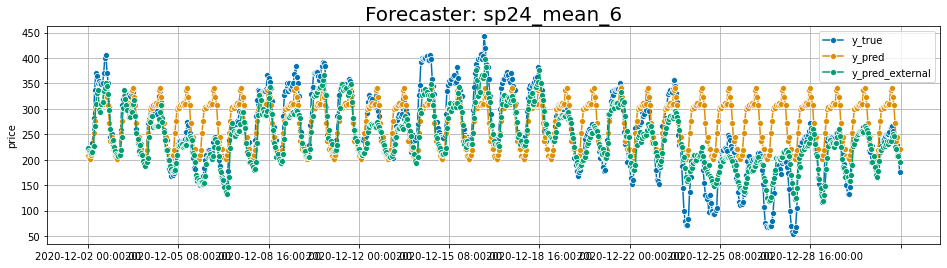

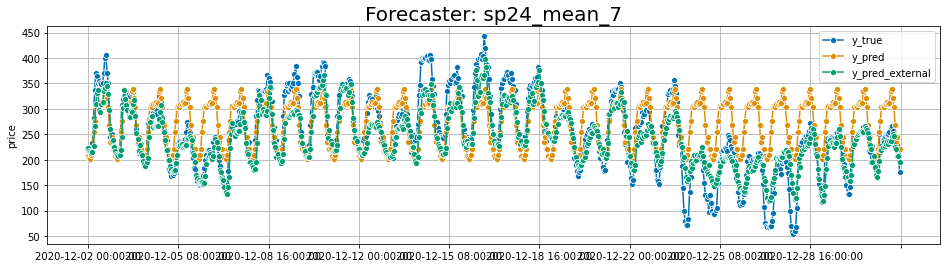

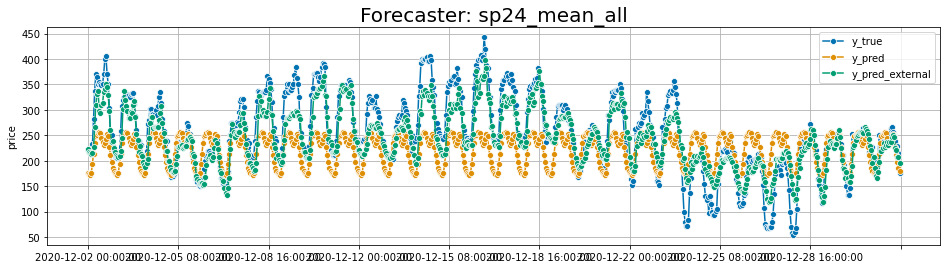

In [11]:
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    forecaster = copy.deepcopy(naive_forecaster)
    rmse_metrics[naive_forecaster_name] = fit_forecaster(
        forecaster, 
        y_train, 
        y_valid, 
        forecaster_name=naive_forecaster_name
    )

In [12]:
rmse_metrics

{'sp1_last': 77.822836434394,
 'sp1_mean_1': 82.35112357899084,
 'sp1_mean_2': 82.98247392872543,
 'sp1_mean_3': 75.52582938835815,
 'sp1_mean_4': 74.96368342093002,
 'sp1_mean_5': 75.6772701653578,
 'sp1_mean_6': 75.78480609570967,
 'sp1_mean_7': 75.91814981032917,
 'sp1_mean_all': 81.28165165286667,
 'sp24_last': 68.65545525079887,
 'sp24_mean_1': 68.65545525079887,
 'sp24_mean_2': 69.7082356031393,
 'sp24_mean_3': 59.74243579308381,
 'sp24_mean_4': 58.72156217986499,
 'sp24_mean_5': 59.60628851588471,
 'sp24_mean_6': 59.691035055874735,
 'sp24_mean_7': 59.85797330429817,
 'sp24_mean_all': 69.4856800871764}

Forecaster sp24_mean_4 results:
Naive forecaster RMSE: 58.72156217986499. External predictions RMSE: 34.117237015574034


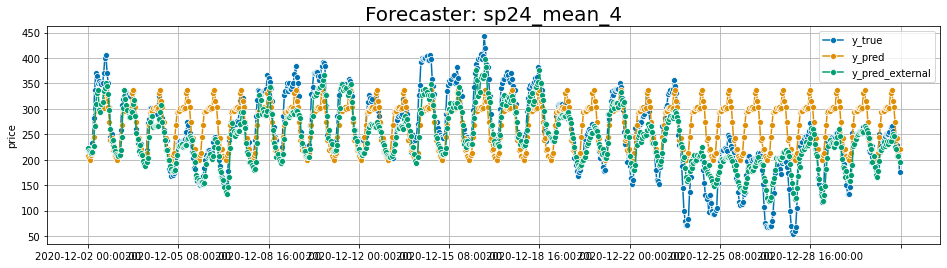

In [13]:
best_forecaster_name = min(rmse_metrics, key=rmse_metrics.get)
best_forecaster = naive_forecasters.get(best_forecaster_name)
best_rmse = fit_forecaster(best_forecaster, y_train, y_valid, forecaster_name=best_forecaster_name)

## Dynamic evaluation

In [25]:
strategy="refit"
initial_window=24 
step=24
forecaster = NaiveForecaster(strategy='last', sp=sp, window_length=None)


fh = [hour for hour in range(1, step+1)]
idx_max = int((len(y_train) - step) / step) + 1
predictions, benchmarks, observed = list(), list(), list()
rmse, rmse_benchmark, prediction_dates = list(), list(), list()
y_benchmark = y_pred_external.iloc[y_pred_external.index==y_valid.index]
for idx in range(idx_max):
    y_train_batch = y_train.iloc[:initial_window+idx*step].copy()
    y_test_batch = y_train.iloc[initial_window+idx*step:initial_window+(idx+1)*step].copy()
    #y_benchmark_batch = y_benchmark.iloc[initial_window+idx*step:initial_window+(idx+1)*step].copy()
    y_benchmark_batch = y_benchmark.iloc[y_benchmark.index.isin(y_test_batch.index)].copy()
    if len(y_test_batch) == step:
        prediction_date = np.unique(y_test_batch.index.date)[0]
        forecaster.fit(y_train_batch)
        y_pred_batch = forecaster.predict(fh)
        predictions.append(y_pred_batch)
        benchmarks.append(y_benchmark_batch)
        observed.append(y_test_batch)
        rmse.append(np.sqrt(mean_squared_error(y_true=y_test_batch, y_pred=y_pred_batch)))
        rmse_benchmark.append(np.sqrt(mean_squared_error(y_true=y_test_batch, y_pred=y_benchmark_batch)))
        prediction_dates.append(prediction_date)
predictions = pd.concat(predictions, axis=0)
benchmarks = pd.concat(benchmarks, axis=0)
observed = pd.concat(observed, axis=0)
results = pd.DataFrame({'predictions': predictions, 'benchmarks': benchmarks, 'observed': observed})
rmse = pd.DataFrame({'date': prediction_dates, 'rmse': rmse, 'rmse_benchmark': rmse_benchmark})

ValueError: Found input variables with inconsistent numbers of samples: [24, 0]

In [30]:
y_test_batch.index

DatetimeIndex(['2018-01-09 00:00:00', '2018-01-09 01:00:00',
               '2018-01-09 02:00:00', '2018-01-09 03:00:00',
               '2018-01-09 04:00:00', '2018-01-09 05:00:00',
               '2018-01-09 06:00:00', '2018-01-09 07:00:00',
               '2018-01-09 08:00:00', '2018-01-09 09:00:00',
               '2018-01-09 10:00:00', '2018-01-09 11:00:00',
               '2018-01-09 12:00:00', '2018-01-09 13:00:00',
               '2018-01-09 14:00:00', '2018-01-09 15:00:00',
               '2018-01-09 16:00:00', '2018-01-09 17:00:00',
               '2018-01-09 18:00:00', '2018-01-09 19:00:00',
               '2018-01-09 20:00:00', '2018-01-09 21:00:00',
               '2018-01-09 22:00:00', '2018-01-09 23:00:00'],
              dtype='datetime64[ns]', name='delivery_start_utc', freq='H')

In [20]:
def evaluate(forecaster, y_train,  y_valid, strategy="refit", initial_window=24, step=24):
    fh = [hour for hour in range(1, step+1)]
    idx_max = int((len(y_train) - step) / step) + 1
    predictions, benchmarks, observed = list(), list(), list()
    rmse, rmse_benchmark, prediction_dates = list(), list(), list()
    y_benchmark = y_pred_external.iloc[y_pred_external.index==y_valid.index]
    for idx in range(idx_max):
        y_train_batch = y_train.iloc[:initial_window+idx*step].copy()
        y_test_batch = y_train.iloc[initial_window+idx*step:initial_window+(idx+1)*step].copy()
        #y_benchmark_batch = y_benchmark.iloc[initial_window+idx*step:initial_window+(idx+1)*step].copy()
        y_benchmark_batch = y_benchmark.iloc[y_benchmark.index==y_test_batch.index].copy()
        if len(y_test_batch) == step:
            prediction_date = np.unique(y_test_batch.index.date)[0]
            forecaster.fit(y_train_batch)
            y_pred_batch = forecaster.predict(fh)
            predictions.append(y_pred_batch)
            benchmarks.append(y_benchmark_batch)
            observed.append(y_test_batch)
            rmse.append(np.sqrt(mean_squared_error(y_true=y_test_batch, y_pred=y_pred_batch)))
            rmse_benchmark.append(np.sqrt(mean_squared_error(y_true=y_test_batch, y_pred=y_benchmark_batch)))
            prediction_dates.append(prediction_date)
    predictions = pd.concat(predictions, axis=0)
    benchmarks = pd.concat(benchmarks, axis=0)
    observed = pd.concat(observed, axis=0)
    results = pd.DataFrame({'predictions': predictions, 'benchmarks': benchmarks, 'observed': observed})
    rmse = pd.DataFrame({'date': prediction_dates, 'rmse': rmse, 'rmse_benchmark': rmse_benchmark})
    return results, rmse

sp = 24
forecaster = NaiveForecaster(strategy='last', sp=sp, window_length=None)
results, rmse = evaluate(
    forecaster=forecaster, 
    y_train=y_train, 
    y_valid=y_valid,
    initial_window=sp,
    step=24
)

ValueError: Lengths must match

In [ ]:
rmse.plot()
plt.grid()

In [ ]:
rmse.mean()

In [ ]:
plot_series(results['predictions'].iloc[:96], results['benchmarks'].iloc[:96],results['observed'].iloc[:96],
            labels=['predicitons', 'benchmark', 'observed'])

In [ ]:
results

In [ ]:
def naive_forecasters_factory():
    naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
    }
    return naive_forecasters

def arima_forecasters_factory():
    return dict()

def benchmark_forecasters_factory():
    benchmark_forecasters = dict()
    benchmark_forecasters.update(naive_forecasters_factory())
    benchmark_forecasters.update(arima_forecasters_factory())
    return benchmark_forecasters

In [ ]:
fh_index = y_test.index
fh = ForecastingHorizon(fh_index, is_relative=False)
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    forecaster = copy.deepcopy(naive_forecaster)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    rmse_metrics[naive_forecaster_name] = rmse

In [ ]:
rmse_metrics

In [ ]:
best_forecaster_name = max(rmse_metrics, key=rmse_metrics.get)
best_forecaster = naive_forecasters.get(best_forecaster_name)
best_forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
rmse_test = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_ext_test))
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')